# BERT with Fastai - SquAD Scratch

In [1]:
from fastai.text import *
from fastai.metrics import *
import torch

from pytorch_transformers import BertForQuestionAnswering, BertTokenizer
import jsonlines

In [2]:
# defining utility functions

def str2tensor(s):
    indices = re.findall("\d+",s)
    return torch.tensor([int(indices[0]), int(indices[1])], dtype=torch.long)

# Creating a config class to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

In [3]:
# defining our configuration
config = Config(
    task = "SquAD",
    testing=False,
    seed = 2019,
    bert_model_name='bert-base-uncased', # can also be exchanged with bert-large 
    pad_idx = 0,
    max_lr=1e-4,
    epochs=1,
    use_fp16=False,
    bs=8, 
    max_seq_len=256, 
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for bert-large
    start_tok = "[CLS]",
    end_tok = "[SEP]",
    mark_fields=True,
)

In [4]:
# setting our data directory
path = Path(".")
data_path = path/"data"

## Loading from CSV

In [5]:
# Load Data
train = pd.read_csv(data_path/"train.csv")
val = pd.read_csv(data_path/"val.csv")

In [6]:
feat_cols = ["question","paragraph"]
label_cols = "indices"

In [7]:
# reduce df sizes if testing
if config.testing:
    train = train[:500]
    val = val[:250]

In [8]:
# dropping rows with na values
train.dropna(inplace=True)
val.dropna(inplace=True)

In [9]:
train_in_range = train.indices.apply(str2tensor).apply(lambda x: True if x[1] < (config.max_seq_len-2) else False)
val_in_range = val.indices.apply(str2tensor).apply(lambda x: True if x[1] < (config.max_seq_len-2) else False)

print("dropping {} out of {} questions in train".format(sum(~train_in_range),len(train)))
print("dropping {} out of {} questions in val".format(sum(~val_in_range),len(val)))

train = train[train_in_range]
val = val[val_in_range]

dropping 889 out of 86660 questions in train
dropping 335 out of 20276 questions in val


In [10]:
# randomizing the order of training data
train = train.sample(frac=1,random_state = config.seed).reset_index(drop=True)
val = val.sample(frac=1, random_state = config.seed).reset_index(drop=True)

## Setting Up the Tokenizer

In [11]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Bert bos and eos tokens and limits the maximum sequence length""" 
        if config.mark_fields:
            sub = 2 # subtraction in totoal seq_length to be made due to adding spcl tokens
            assert "xxfld" in t
            t = t.replace("xxfld 1","") # remove the xxfld 1 special token from fastai
            # converting fastai field sep token to Bert
            t = re.split(r'xxfld \d+', t) 
            res = []
            for i in range(len(t)-1): # loop over the number of additional fields and the Bert sep
                res += self._pretrained_tokenizer.tokenize(t[i]) + [config.end_tok]
                sub += 2 # increase our subtractions since we added more spcl tokens
            res += self._pretrained_tokenizer.tokenize(t[-1]) # add the last sequence
            return [config.start_tok] + res[:self.max_seq_len - sub] + [config.end_tok] 
        
        res = self._pretrained_tokenizer.tokenize(t)
        return [config.start_tok] + res[:self.max_seq_len - sub] + [config.end_tok]

In [12]:
# create fastai tokenizer for bert
bert_tok = BertTokenizer.from_pretrained(config.bert_model_name)

fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [13]:
# Setting up pre-processors
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False, mark_fields=config.mark_fields)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_bert_vocab, **kwargs)


def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Bert
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Bert model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

## Setting up the DataBunch

In [14]:
def pad_collate_qa(samples:BatchSamples, pad_idx:int=config.pad_idx, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len = max([len(s[0]) for s in samples])
    res_x = torch.zeros(len(samples), max_len).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: res_x[i,-len(s[0]):] = LongTensor(s[0])
        else:         res_x[i,:len(s[0]):] = LongTensor(s[0])
    if backwards: res_x = res_x.flip(1)
    res_y = torch.stack([s[1] for s in samples])
    return res_x, res_y

In [15]:
# Creating a Bert specific DataBunch class
class BertDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Bert"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate_qa, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

In [16]:
# Creating a class for Bert Text Lists
class BertTextList(TextList):
    _bunch = BertDataBunch
    _label_cls = TextList

In [17]:
# Creating a special class for QA labels 
class QAItemList(ItemList):    
    def get(self, i):
        f = super().get(i)
        return str2tensor(f)

In [18]:
# loading the tokenizer and vocab processors
processor = get_bert_processor(tokenizer=fastai_tokenizer, vocab=fastai_bert_vocab)

# creating our databunch 
data = ItemLists(".", BertTextList.from_df(train, ".", cols=feat_cols, processor=processor),
                      BertTextList.from_df(val, ".", cols=feat_cols, processor=processor)
                ) \
       .label_from_df(cols=label_cols, label_cls=QAItemList) \
       .databunch(bs=config.bs,pad_first=False)

## Building the Model

In [19]:
# CustomBertModel
class CustomBertModel(nn.Module):
    def __init__(self):
        super(CustomBertModel,self).__init__()
        self.bert = BertForQuestionAnswering.from_pretrained(config.bert_model_name)
        self.bert.train()
        
    def forward(self, input_ids,token_type_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids)
        return outputs

In [20]:
# defining the loss function
def cross_entropy_qa(input, target):
    """
    Summing the cross entropy loss from the starting and ending indices. 
    """
    loss = torch.add(F.cross_entropy(input[0], target[:,0]) , F.cross_entropy(input[1], target[:,1]))
    return loss 

In [21]:
# defining the evaluation metric
def acc_qa(input,target):
    """
    Taking the average between the accuracies of predicting the start and ending indices
    """
    return (accuracy(input[0], target[:,0]) + accuracy(input[1], target[:,1]))/2

In [22]:
bert_model = CustomBertModel()

In [23]:
learn = Learner(data, bert_model, loss_func=cross_entropy_qa, metrics=acc_qa)

In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


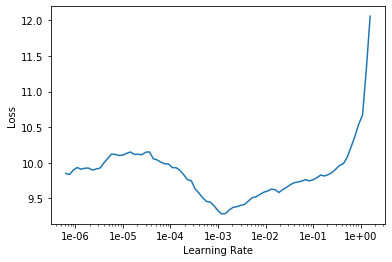

In [26]:
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(2, max_lr=config.max_lr)

epoch,train_loss,valid_loss,acc_qa,time
0,2.738323,2.866107,0.608420,1:28:27
1,1.783770,2.350716,0.675969,1:36:06
